In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import sqrt

from utils.mog_utils import *

import itertools


In [11]:
from utils.kde_mog import * 
from utils.mog_utils import *
from utils.model_utils import *
from utils.edm_utils import  *

device = "cuda" if torch.cuda.is_available() else "cpu"

target = GMM(dim=2, n_mixes=40,loc_scaling=40, log_var_scaling=1,device=device)
true_samples = target.sample((10000,))

# Wrap KDE score (use k for speed when N large; try k=128 or 256)
def kde_score_wrapper(x: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
        return score_kde_2d(true_samples, x, sigma)

# Sample with EDM + Tweedie
samples = edm_sample_2D_kde(
        kde_score_wrapper,
        device=device,
        num_samples=4000,
        num_steps=100,
        sigma_min=0.65,
        sigma_max=40.0,
        rho=7.0,
        S_churn=0.0,     # you can try small churn like 0.1–0.3
        S_min=0.0,
        S_max=float("inf"),
        S_noise=1.0
    )



100%|██████████| 100/100 [00:01<00:00, 74.57step/s]


N sweep:   0%|          | 0/15 [00:00<?, ?it/s]

N sweep: 100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


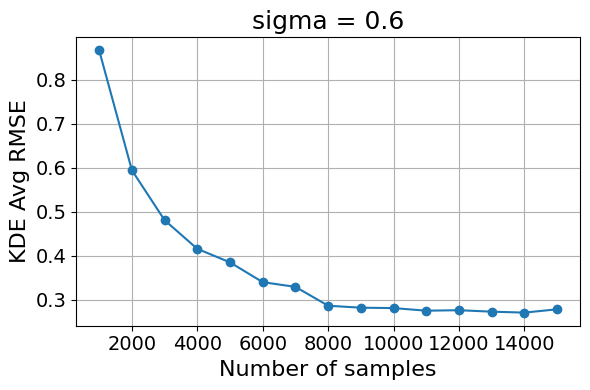

In [21]:
teacher_score_func=get_BatchGMM40_true_score
X0_all = true_samples.to(device)

# --------- EDM noise schedule helper ---------
def edm_sigma_schedule(num_steps=50, sigma_min=0.1, sigma_max=40, rho=7.0, device="cpu"):
    step_indices = torch.arange(num_steps, device=device)
    sigmas = (sigma_max ** (1 / rho) +
              step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    return sigmas

sigma = 0.6
# --------- Config ---------
device = "cuda" if torch.cuda.is_available() else "cpu"
M_eval = 256  # evaluation batch size per sigma
Ns = np.arange(1000, 15001, 1000)  
sigmas = edm_sigma_schedule(num_steps=50, sigma_min=sigma, sigma_max=sigma, rho=7.0, device=device)

errors_vs_N = []

# --------- Main loop ---------
for N in tqdm.tqdm(Ns, desc="N sweep"):
    # Subsample KDE dataset
    idx_subset = torch.randperm(len(X0_all), device=device)[:N]
    X0_subset = X0_all[idx_subset]

    rmse_across_t = []
    for sigma_val in sigmas:
        sigma_tensor = torch.full((M_eval, 1), sigma_val.item(), device=device)
        idx_eval = torch.randint(0, len(X0_all), (M_eval,), device=device)
        eps = torch.randn(M_eval, 2, device=device)
        Xt_eval = X0_all[idx_eval] + sigma_val * eps

        score_true = teacher_score_func(Xt_eval, sigma_tensor*0+1, sigma_tensor)
        score_est = score_kde_2d(X0_subset, Xt_eval, sigma_tensor)

        rmse = torch.sqrt(torch.mean((score_est - score_true) ** 2)).item()
        rmse_across_t.append(rmse)

    errors_vs_N.append(np.mean(rmse_across_t))

# --------- Plot ---------
plt.figure(figsize=(6,4))
plt.plot(Ns, errors_vs_N, marker='o')

plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("KDE Avg RMSE", fontsize=16)
plt.title(f"sigma = {sigma}", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.savefig("KDE_error.png", dpi=300)  # save high-res PNG
plt.show()

In [ ]:
class ScoreNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=400):
        super(ScoreNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, sigma):
        sigma = sigma.expand(-1, x.shape[-1])  # Expand sigma to match input shape
        x_concat = torch.cat([x, sigma], dim=-1)
        return self.net(x_concat)

In [ ]:
# class EDMLoss:
#     def __init__(self, sigma_min=0.002, sigma_max=30, sigma_data=10, rho=7.0, device='cpu'):
#         self.sigma_min = sigma_min
#         self.sigma_max = sigma_max
#         self.sigma_data = sigma_data
#         self.rho = rho
#         self.device = device

#     def sample_sigma(self, batch_size):
#         # Sample t ~ Uniform[0, 1]
#         rand_t = torch.rand(batch_size, 1, device=self.device)

#         # Continuous EDM noise schedule
#         sigma = (self.sigma_max ** (1 / self.rho) +
#                  (self.sigma_min ** (1 / self.rho) - self.sigma_max ** (1 / self.rho)) * rand_t) ** self.rho
#         return sigma  # Shape: [B, 1]

#     def __call__(self, net, y):
#         batch_size = y.shape[0]

#         sigma = self.sample_sigma(batch_size)  # Sample continuous sigma per data point
#         sigma = sigma.to(y.device)

#         weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
#         noise = torch.randn_like(y) * sigma
#         D_yn = net(y + noise, sigma)
#         loss = weight * ((D_yn - y) ** 2)
#         return loss.mean()


class EDMLoss:
    def __init__(self, sigma_min=0.1, sigma_max=20, sigma_data=10, rho=7.0, device='cuda:1'):
         self.sigma_min = sigma_min
         self.sigma_max = sigma_max
         self.sigma_data = sigma_data
         self.rho = rho
         self.device = device

    def sample_sigma(self, batch_size):
         # Sample t ~ Uniform[0, 1]
         #rand_t = torch.rand(batch_size, 1, device=self.device)

         # Continuous EDM noise schedule
         #sigma = (self.sigma_max ** (1 / self.rho) +
          #        (self.sigma_min ** (1 / self.rho) - self.sigma_max ** (1 / self.rho)) * rand_t) ** self.rho
          rand_t = torch.rand(batch_size, 1, device=self.device)
          sigma = self.sigma_min + torch.pow(rand_t,1) * (self.sigma_max - self.sigma_min)
          return sigma
         #return sigma  # Shape: [B, 1]

    def __call__(self, net, y):
        sigma = self.sample_sigma(y.shape[0])
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        n = torch.randn_like(y) * sigma.to(self.device)
        D_yn = net(y + n, sigma).to(self.device)
        loss = weight * ((D_yn - y) ** 2)
        return loss.mean()

In [ ]:
@torch.no_grad()
def edm_sample_2D(model, num_samples=1000, num_steps=100, sigma_min=0.1, sigma_max=20, rho=7.0,
                   S_churn=0, S_min=0, S_max=float('inf'), S_noise=1.0, device='cuda:1'):
    """
    Sampling from a trained EDM model in 2D using Heun's method with optional noise control.
    """

    # Initialize samples from standard Gaussian
    latents = torch.randn([num_samples, 2], device=device)  # 2D case

    # Time step discretization.
    step_indices = torch.arange(num_steps, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([torch.tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop
    x_next = latents * t_steps[0]
    for i, (t_cur, t_next) in tqdm(list(enumerate(zip(t_steps[:-1], t_steps[1:]))), unit='step'):  # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily (if within range)
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = torch.tensor(t_cur + gamma * t_cur,device=device).expand(x_cur.shape[0], 1)

        # Ensure `t_cur` is a tensor before using it in subtraction
        t_cur_tensor = torch.tensor(t_cur,  device=device)
        x_hat = x_cur + (t_hat ** 2 - t_cur_tensor ** 2).sqrt() * S_noise * torch.randn_like(x_cur)

        # Euler step
        denoised = model(x_hat, t_hat)  # Now t_hat has shape [b,1]
        d_cur = (x_hat - denoised) / t_hat
        t_next = torch.tensor(t_next, device=device).expand(x_hat.shape[0], 1)  # Ensure shape consistency
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction (Heun's method)
        if i < num_steps - 1:
            denoised = model(x_next, t_next)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

    return x_next.cpu()


def plot_sampled_data(sampled_data):
    plt.figure(figsize=(8, 8))
    plt.scatter(sampled_data[:, 0], sampled_data[:, 1], alpha=0.5, label='Sampled Data')
    plt.xlim(-50, 50)  # Set x-axis limits
    plt.ylim(-50, 50)  # Set y-axis limits
    plt.legend()
    plt.title("Sampled Data")
    plt.show()

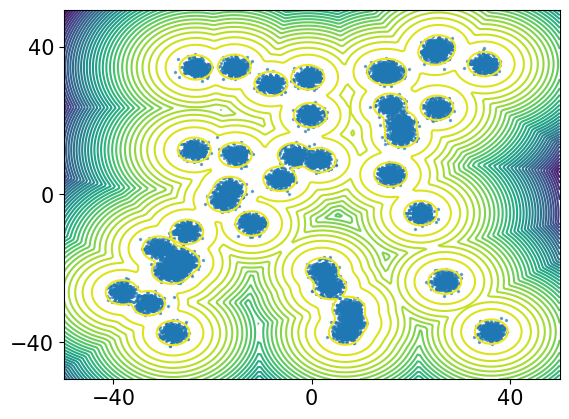

In [ ]:
MoG40 = GMM(dim = 2, n_mixes = 40, loc_scaling = 40, log_var_scaling = 1)
data = MoG40.sample((20480,))

trainingset = torch.utils.data.TensorDataset(data)
dataloader = torch.utils.data.DataLoader(trainingset, batch_size=1024, shuffle=True)
def plot_sampled_data(sampled_data):
    plot_contours(MoG40.log_prob,samples = sampled_data, bounds=(-50,50),n_contour_levels=40,grid_width_n_points=200)
plot_sampled_data(data)

In [ ]:
def train_edm(model, dataloader, epochs=1000, batch_size=512, lr=5e-4, device='cuda:1'):
    device = torch.device(device)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = EDMLoss(sigma_max=40,sigma_data=10)

    for epoch in tqdm(range(epochs)):
        for x0, in dataloader:
            x0 = x0.to(device)  # Get batch from MoG40
            loss = criterion(model, x0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = criterion(model, x0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 2000 == 0:
            model.eval().requires_grad_(False)
            with torch.no_grad():
                sample = edm_sample_2D(model,num_samples=10000,sigma_max=40)
            print(f"Epoch {epoch}: Loss = {loss.item()}")
            plot_sampled_data(sample)
            model.train().requires_grad_(True)

            torch.save(model.state_dict(), "edm_network__.pth")

In [ ]:
DNet = ScoreNet(input_dim=2, hidden_dim=400).to('cuda:1')
# train_score(score_net,dataloader,epochs=30000,lr=1e-4,device='cuda:1')


  0%|          | 0/100000 [00:00<?, ?it/s]/tmp/ipykernel_1829860/3703577979.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_steps = torch.cat([torch.tensor(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
/tmp/ipykernel_1829860/3703577979.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_hat = torch.tensor(t_cur + gamma * t_cur,device=device).expand(x_cur.shape[0], 1)
/tmp/ipykernel_1829860/3703577979.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_cur_tensor = torch.tensor(t_cur,  device=device)
/tmp/ipykernel_18298

Epoch 0: Loss = 56.17511749267578


  0%|          | 0/100000 [00:01<?, ?it/s]


KeyboardInterrupt: 

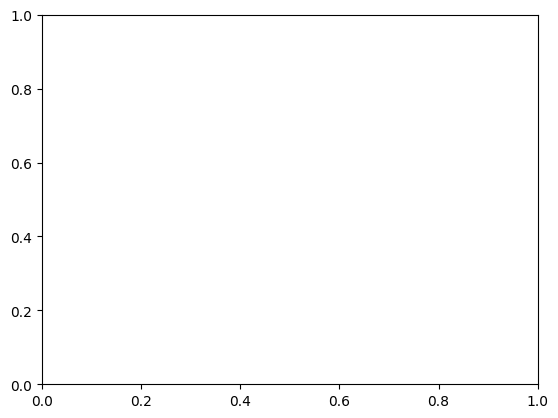

In [ ]:
train_edm(DNet, dataloader, epochs=100000, batch_size=1024, lr=5e-5, device='cuda:1')
